In [ ]:
# 파일 불러오기 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # 필요한 패키지 임포트 

try: 
  os.mkdir(path= "/content/drive/My Drive/colab notebooks/textmining/result/")
except:
  print("already exists")

already exists


In [ ]:
# 저장할 경로 설정 
save_dir = "/content/drive/My Drive/colab notebooks/textmining/result/"

In [ ]:
# Knolpy 설치 
!pip install konlpy

     |████████████████████████████████| 19.4MB 162kB/s 
     |████████████████████████████████| 460kB 41.0MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# 필요한 패키지를 임포트합니다 
import pandas as pd # 데이터프레임 형식 데이터를 다루기 위해 필요합니다 
from konlpy.tag import Okt #twitter 형태소 분석기를 불러옵니다 
import nltk #자연어 처리 프로그램입니다 
import csv #csv 파일을 읽기 위해 필요합니다 
from tqdm import tqdm_notebook as tqdm #진행 상황을 시각화해줍니다 
import datetime as dt # 시간을 계산하기 위해 필요합니다. 

In [ ]:
# 진행상황을 텍스트로 표현하기 위한 함수입니다 
def logging(msg):
   a = dt.datetime.strftime(dt.datetime.now(), "%Y-%m-%d %H:%M:%S")
   b = "| " + a.split(" ")[0] + " | " + a.split(" ")[1] + " | " + msg + "\n"
   print(b)

In [ ]:
# 감정 분석을 진행하기 위해 미리 수집한 데이터를 불러옵니다.
blog_data = pd.read_csv("/content/drive/My Drive/colab notebooks/textmining/data/2020_1 final3.csv", encoding = "UTF-8") 
blog_data.head()

,student,structure,effort,evaluation
0,1,"이론 설명이 주가 된다. 하지만, 이론 설명만으로는 한 나라의 문화를 모두 이해하는...","매 수업 전 예습을 해서 오늘 배울 내용이 무엇인지를 먼저 파악했고, 수업이 끝난 ...",프랑스문화권연구 과목을 처음 들어봐서 기존의 대면 수업의 경우 어떤 방식으로 했는지...
1,2,"교수님께서 해당 주차에 들어야 할 강의를 월요일, 수요일 강의로 나누어 차례로 스노...",수업을 제때제때 듣고 수업 자료에 필기를 했다. 수업에 관해 궁금한 것이 생기면 교...,온라인 강의를 통해 전에 들었던 강의를 다시 들을 수 있다는 것은 좋았다. 하지만 ...
2,3,"이론 강의였으므로 수업 전체는 온라인으로 진행되었고, 1주일에 영상과 참고 자료가 ...","도움이 되었던 수업 방법은 직접 자료를 프린트해 필기를 하는 방식이었는데, 단순히 ...",과제 없이 수업이 진행된 점도 도움이 되었던 것 같습니다. 학습 평가 자체는 시험으...
3,4,"이론과 실습이 병행되고 1회에 2시간, 주 2회 진행되는 수업이다. 온라인 수업으로...",수업 시간에 집중해서 들으며 이해한 내용을 최대한 필기로 남겨두려 하였다. 무엇보다...,수업 내용은 전체적으로 흥미롭고 유익했다. 중간중간 지금 배우는 것들이 실생활에서 ...
4,5,온라인으로 수업을 하게 되면서 이해를 못 하거나 궁금한 점이 생길 학생들을 걱정하여...,NaN,온라인 퀴즈와 과제를 실시했기에 기말고사에는 다른과목과 다르게 중간과 기말고사의 범...


In [ ]:
# 원데이터 결측치 확인: effort 칼럼에서 32개 -> 해당 셀에 내용이 없기 때문 

pd.isnull(blog_data)  # 결측이면 True, 결측이 아니면 False
blog_data.isnull().sum()

student        0
structure      0
effort        32
evaluation     0
dtype: int64

In [ ]:
# 원데이터 결측치 행(row)별로 확인 

blog_data.isnull().sum(1)

0      0
1      0
2      0
3      0
4      1
      ..
124    0
125    0
126    1
127    0
128    0
Length: 129, dtype: int64

In [ ]:
# 원데이터 결측치 처리하기 -> 비어있는 셀에 "없음"으로 대체 
# "없음" = effort에 대한 학생이 기록한 내용이 없음 

blog_data = blog_data.fillna("없음")
blog_data

,student,structure,effort,evaluation
0,1,"이론 설명이 주가 된다. 하지만, 이론 설명만으로는 한 나라의 문화를 모두 이해하는...","매 수업 전 예습을 해서 오늘 배울 내용이 무엇인지를 먼저 파악했고, 수업이 끝난 ...",프랑스문화권연구 과목을 처음 들어봐서 기존의 대면 수업의 경우 어떤 방식으로 했는지...
1,2,"교수님께서 해당 주차에 들어야 할 강의를 월요일, 수요일 강의로 나누어 차례로 스노...",수업을 제때제때 듣고 수업 자료에 필기를 했다. 수업에 관해 궁금한 것이 생기면 교...,온라인 강의를 통해 전에 들었던 강의를 다시 들을 수 있다는 것은 좋았다. 하지만 ...
2,3,"이론 강의였으므로 수업 전체는 온라인으로 진행되었고, 1주일에 영상과 참고 자료가 ...","도움이 되었던 수업 방법은 직접 자료를 프린트해 필기를 하는 방식이었는데, 단순히 ...",과제 없이 수업이 진행된 점도 도움이 되었던 것 같습니다. 학습 평가 자체는 시험으...
3,4,"이론과 실습이 병행되고 1회에 2시간, 주 2회 진행되는 수업이다. 온라인 수업으로...",수업 시간에 집중해서 들으며 이해한 내용을 최대한 필기로 남겨두려 하였다. 무엇보다...,수업 내용은 전체적으로 흥미롭고 유익했다. 중간중간 지금 배우는 것들이 실생활에서 ...
4,5,온라인으로 수업을 하게 되면서 이해를 못 하거나 궁금한 점이 생길 학생들을 걱정하여...,없음,온라인 퀴즈와 과제를 실시했기에 기말고사에는 다른과목과 다르게 중간과 기말고사의 범...
...,...,...,...,...
124,125,"이 강의는 전부 비대면으로 실시되었고, 교수님께서는 음성녹음 강의와 피피티 자료, ...","또한, 학우들과 함께 동영상을 시청하고 토론했다면 다양하고 흥미로운 의견들이 나왔을...","학교에 직접 간 적도 두 번 정도였고, 학과의 동기들과도 실제로 만나지 못하고 실시..."
125,126,"수업은 기본적으로 강의내용을 한글파일로 정리해서 미리 올려주시고, 강의에서는 교수님...","일본대중문화기행은 교수님께서 강의 자료를 준비해주시긴 하지만, 자료에서 생략하는 부...",타국의 문화를 배우는 강의 내용특성상 동영상 자료를 십분 활용하는 것이 학생들의 내...
126,127,"수업은 화, 목 일주일에 2번, 매 수업마다 1시간 15분 동안 진행되는 수업이었습...",없음,우선 녹화본 수업을 들으며 제가 느꼈던 가장 불편함 점은 교수님과 원활한 의사소통이...
127,128,", 코로나로 인해 전면 비대면 수업으로 진행되었다. 화/목요일이 강의 날이었는데, ...",없음,"학우들과 함께 푸는 문제여서 모르는 부분이 있으면 학우들과 토의를 통해 해결하였고,..."


In [ ]:
"""
감정 분석 결과를 저장할 새로운 열 5개를 데이터셋에 추가합니다.
tokens에는 게시글을 토큰화한 결과를 저장합니다.
pos/nuet/neg 는 게시글의 긍정, 중립, 부정 점수를 저장합니다.
sentiment 는 게시글의 감정 판정 결과를 저장합니다. 
"""

blog_data["tokens"] = None
blog_data["pos"] = None
blog_data["neut"] = None
blog_data["neg"] = None
blog_data["sentiment"] = None

In [ ]:
# '#단어: 부정점수: 중립점수: 긍정점수' 형식의 감정 사전을 만듭니다. 
# 사전 이름은 "lexicon" 이라 명명합니다. 

lexicon = dict()

with open('/content/drive/My Drive/colab notebooks/textmining/polarity.csv', 'r', encoding='utf-8-sig') as polarity:
    #next(polarity) # csv 파일에서 첫 행 건너뛰는 용도 
    for line in csv.reader(polarity):
        key = str()
        for word in line[0].split(';'):
            key += word.split('/')[0]

        lexicon[key] = {'Neg': line[3], 'Neut': line[4], 'Pos': line[6]}

In [ ]:
# 주어진 텍스트에 대해 토큰화 작업을 하는 함수를 정의합니다. 

def get_token(text):
    pos = []
    tokenizer = Okt() #twitter 형태소 분석기를 불러옵니다.
    if isinstance(text, float) == True: # 주어진 텍스트가 공백일 시 건너뜁니다.
        tokens = "Nothing"
    else:
        tokens = tokenizer.pos(text)
    
    tags = ['Noun', 'Adjective', 'Verb', 'Adverb'] #형태소 중 명사, 형용사, 동사, 부사만 수집합니다. 
    #불용어를 정의합니다.         *불용어: 문장에서 내용을 나타내는데 큰 역할을 하지 않은 기능어. 
    stop_words = ["등", "이", "하", "않", "있", "대하", "하지만", "지", "일", "속", "하", "되", "수업", "및", "교수님", "교수", "강의",
                 "서", "있다", "것", "되었습니다", "하는", "한다", "했다", "주", "하였습니다", "대", "했습니다", "하여", "해보세요",
                  "있는", "입니다", "있음", "되거나", "할", "있는", "관련", "해", "학생","학우님","학우", "없음",
                  "월", "화", "수","목", "금", "토", "일", "를", "나", "그", "위", "고","와", "하며", "의", "가",
                 "하겠습니다", "해야", "몇", "는", "전", "이를","하고", '시킵니다', '된', '있습니다', '제', "이론",
                  "월요일", "화요일", "수요일", "목요일", "금요일", "토요일", "일요일",
                 "있는데요", "있는데", "볼", "로", "은", "총", "우","보였다", "하기", "후", "간", "이번", "때","원",
                 "합시다", "중", "과", "저","분","방","임", "된다","날","함", "있으며","개", "될","며", "보자","합니다","안녕하세요",
                 "같습니다","조","다", "스","가를", "경우", "무엇","대한","내용", "위해", "이후","현재", "보시",
                 "우리", "없는", "모두","언제","어디", "세","사", "미","데", "료", "그린",
                 "한", "꾸준히", "하겠다", "리","두었다", "또한", "들어","통해", "바란다", "다음"," 이어",
                 "됨", "됨", "됌", "또", "됐다", "촬용", "분야", "발표", "매일", "점","출처", "기반", "예정", 
                  "오전", "계획", "오늘", "더", "마감", "분야", "상","뜻", "특징", "업계", "크게","하나", 
                 "콤", "재", "해서", "같다", "곳", "역시","라며", "처", "첫", "보면", "창", "출", "번", "각각","남기","겸","보기"]
    
    for token in tokens:
        if not tokens == "Nothing":
          if token[1] in tags:
            if not token[0] in stop_words: #불용어는 제외하고 
              pos.append(token[0])  #토큰 수집
        else:
           continue

    return pos

In [ ]:
#감성분석 함수 정의
def get_sentiment(token_list):
    cnt = 0 # 평균을 내기 위해 토큰 개수를 셉니다. 
    pos = 0
    neut = 0
    neg = 0
    sentiment = None
    for token in token_list:
        try:
            #lexicon에 토큰이 없으면 건너뜁니다.
            pos += float(lexicon[token]["Pos"]) # 토큰들의 긍정점수를 구해서 더합니다. 
            neut += float(lexicon[token]["Neut"]) # 토큰들의 중립점수를 구해서 더합니다.
            neg += float(lexicon[token]["Neg"]) # 토큰들의 부정점수를 구해서 더합니다.
            cnt += 1
        except:
            continue
            
    if not cnt == 0:   
        pos = pos/cnt # 게시글의 긍정점수 평균을 구합니다. 
        neut = neut/cnt # 게시글의 중립점수 평균을 구합니다. 
        neg = neg/cnt # 게시글의 부정점수 평균을 구합니다. 

        # 논리구조를 통해 게시글의 최종 감정을 판정합니다. 
        # 긍정/중립/부정 점수를 비교해서 가장 높은 점수의 감정을 게시글의 감정으로 판정합니다. 
        if pos > neg:
            if pos > neut:
                sentiment = "positive"
            else:
                sentiment = "neutral"
        elif pos < neg:
            if neg > neut:
                sentiment = "negative"
            else:
                sentiment = "neutral"
        else:
            if pos > neut:
                sentiment = "positive and negative"
            else:
                sentiment = "neutral"   
                
        return pos, neut, neg, sentiment
    else: 
        return [None, None, None, None]

In [ ]:
# 앞서 정의한 토큰화, 감정 분석 함수를 한 번에 실행하는 함수입니다.
# 칼럼 evaluation(학생의 수업평가) 토큰화 및 감성분석

def execute_sentiment_analysis(data, lexicon):

  logging("주어진 텍스트에 대해 감정 분석을 시작합니다.")

  for i in tqdm(range(0, len(data))):
    token_list = get_token(data["evaluation"][i])
    data["pos"][i], data["neut"][i], data["neg"][i], data["sentiment"][i] = get_sentiment(token_list)
    data["tokens"][i] = token_list

  
  #csv 파일로 저장하기
  file_name = "/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis" + ".csv"
  data.to_csv(file_name, index = False, encoding = "utf-8-sig")
  logging("텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.")

  return data

In [ ]:
eval_sentiment_result = execute_sentiment_analysis(blog_data, lexicon)
logging("결과 일부를 출력합니다")
eval_sentiment_result[["tokens","pos","neut","neg","sentiment"]].head(129)

| 2020-11-13 | 11:04:18 | 주어진 텍스트에 대해 감정 분석을 시작합니다.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()



| 2020-11-13 | 11:04:26 | 텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.

| 2020-11-13 | 11:04:26 | 결과 일부를 출력합니다



,tokens,pos,neut,neg,sentiment
0,"[프랑스, 문화, 연구, 과목, 처음, 봐서, 기존, 대면, 어떤, 방식, 했는지는...",0.628501,0.0622566,0.279012,positive
1,"[온라인, 들었던, 다시, 들을, 있다는, 좋았다, 아무래도, 현장, 몰입, 편이,...",0.419899,0.120597,0.352752,positive
2,"[과제, 없이, 진행, 점도, 도움, 되었던, 학습, 평가, 자체, 시험, 충분하게...",0.536883,0.0815146,0.308025,positive
3,"[전체, 흥미, 유익했다, 중간, 중간, 지금, 배우는, 실생활, 어떻게, 응용, ...",0.49704,0.103796,0.275107,positive
4,"[온라인, 퀴즈, 과제, 실시, 했기에, 기말고사, 과목, 다르게, 중간, 기말고사...",0.448135,0.0541859,0.397263,positive
...,...,...,...,...,...
124,"[학교, 직접, 적도, 두, 정도, 였고, 학과, 동기, 실제, 만나지, 못, 실시...",0.435994,0.0379631,0.446303,negative
125,"[타국, 문화, 배우는, 특성, 동영상, 자료, 십분, 활용, 이해, 참여, 유도,...",0.475311,0.0325009,0.429509,positive
126,"[우선, 녹화, 본, 들으며, 느꼈던, 가장, 불편함, 원활한, 의사소통, 불가능하...",0.454694,0.110844,0.339423,positive
127,"[함께, 푸는, 문제, 모르는, 부분, 있으면, 토의, 해결, 하였고, 질의, 메일...",0.444726,0.0890553,0.355678,positive


In [ ]:
pd.isnull(sentiment_result) 
sentiment_result.isnull().sum()

student       0
structure     0
effort        0
evaluation    0
tokens        0
pos           0
neut          0
neg           0
sentiment     0
dtype: int64

In [ ]:
# 앞서 정의한 토큰화, 감정 분석 함수를 한 번에 실행하는 함수입니다.
# 칼럼 effort 토큰화 및 감성분석

def execute_sentiment_analysis2(data, lexicon):

  logging("주어진 텍스트에 대해 감정 분석을 시작합니다.")

  for i in tqdm(range(0, len(data))):
    token_list = get_token(data["effort"][i])
    data["pos"][i], data["neut"][i], data["neg"][i], data["sentiment"][i] = get_sentiment(token_list)
    data["tokens"][i] = token_list

  
  #csv 파일로 저장하기
  file_name = "/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis2" + ".csv"
  data.to_csv(file_name, index = False, encoding = "utf-8-sig")
  logging("텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.")

  return data

In [ ]:
effort_sentiment_result = execute_sentiment_analysis2(blog_data, lexicon)
logging("결과 일부를 출력합니다")
effort_sentiment_result[["tokens","pos","neut","neg","sentiment"]].head(129)

| 2020-11-13 | 11:05:22 | 주어진 텍스트에 대해 감정 분석을 시작합니다.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()



| 2020-11-13 | 11:05:24 | 텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.

| 2020-11-13 | 11:05:24 | 결과 일부를 출력합니다



,tokens,pos,neut,neg,sentiment
0,"[매, 예습, 배울, 인지, 먼저, 파악, 했고, 끝난, 이해, 하려고, 노력, 이...",0.480861,0.137363,0.366392,positive
1,"[제때, 제때, 듣고, 자료, 필기, 관해, 궁금한, 생기, 질문, 헷갈리거나, 여...",0.439394,0.272727,0.287879,positive
2,"[도움, 되었던, 방법, 직접, 자료, 프린트, 필기, 방식, 이었는데, 단순히, ...",0.364099,0.0393719,0.471393,negative
3,"[시간, 집중, 들으며, 이해, 최대한, 필기, 남겨, 두려, 하였다, 학기, 온라...",0.349676,0.127181,0.436308,negative
4,[],None,None,None,None
...,...,...,...,...,...
124,"[함께, 동영상, 시청, 토론, 했다면, 다양하고, 흥미로운, 의견, 나왔을, 모든...",0.537191,0.101852,0.281636,positive
125,"[대중문화, 기행, 자료, 준비, 해주시긴, 자료, 생략, 부분, 외, 추가, 되는...",0.222222,0.291667,0.402778,negative
126,[],None,None,None,None
127,[],None,None,None,None


In [ ]:
# "없음"이라고 표시된 부분 결측값이 나타남 

pd.isnull(effort_sentiment_result)
effort_sentiment_result.isnull().sum(1)

0      0
1      0
2      0
3      0
4      4
      ..
124    0
125    0
126    4
127    4
128    0
Length: 129, dtype: int64

In [ ]:
# "없음"이라고 표시된 행 지우기 

effort_sentiment_result = effort_sentiment_result.dropna(axis=0)
effort_sentiment_result

,student,structure,effort,evaluation,tokens,pos,neut,neg,sentiment
0,1,"이론 설명이 주가 된다. 하지만, 이론 설명만으로는 한 나라의 문화를 모두 이해하는...","매 수업 전 예습을 해서 오늘 배울 내용이 무엇인지를 먼저 파악했고, 수업이 끝난 ...",프랑스문화권연구 과목을 처음 들어봐서 기존의 대면 수업의 경우 어떤 방식으로 했는지...,"[매, 예습, 배울, 인지, 먼저, 파악, 했고, 끝난, 이해, 하려고, 노력, 이...",0.480861,0.137363,0.366392,positive
1,2,"교수님께서 해당 주차에 들어야 할 강의를 월요일, 수요일 강의로 나누어 차례로 스노...",수업을 제때제때 듣고 수업 자료에 필기를 했다. 수업에 관해 궁금한 것이 생기면 교...,온라인 강의를 통해 전에 들었던 강의를 다시 들을 수 있다는 것은 좋았다. 하지만 ...,"[제때, 제때, 듣고, 자료, 필기, 관해, 궁금한, 생기, 질문, 헷갈리거나, 여...",0.439394,0.272727,0.287879,positive
2,3,"이론 강의였으므로 수업 전체는 온라인으로 진행되었고, 1주일에 영상과 참고 자료가 ...","도움이 되었던 수업 방법은 직접 자료를 프린트해 필기를 하는 방식이었는데, 단순히 ...",과제 없이 수업이 진행된 점도 도움이 되었던 것 같습니다. 학습 평가 자체는 시험으...,"[도움, 되었던, 방법, 직접, 자료, 프린트, 필기, 방식, 이었는데, 단순히, ...",0.364099,0.0393719,0.471393,negative
3,4,"이론과 실습이 병행되고 1회에 2시간, 주 2회 진행되는 수업이다. 온라인 수업으로...",수업 시간에 집중해서 들으며 이해한 내용을 최대한 필기로 남겨두려 하였다. 무엇보다...,수업 내용은 전체적으로 흥미롭고 유익했다. 중간중간 지금 배우는 것들이 실생활에서 ...,"[시간, 집중, 들으며, 이해, 최대한, 필기, 남겨, 두려, 하였다, 학기, 온라...",0.349676,0.127181,0.436308,negative
6,7,수업은 매주 수업 시간에 맞추어 온라인 강의를 올려주었다. 월/수 오전 9시 분반 ...,"항상 교수님의 강의를 미리 수강하면서, 모르는 점을 빨리 깨우치기 위해 노력했다. ...",\n사실 통계는 가장 자신 없는 과목이라 더더욱 열심히 따라가려고 노력했다. 하지만...,"[항상, 미리, 수강, 하면서, 모르는, 빨리, 깨우치기, 노력, 이해, 되지, 않...",0.4778,0.0972036,0.366086,positive
...,...,...,...,...,...,...,...,...,...
120,121,기초 독일어는 녹화 강의와 줌 강의를 병행하며 진행되었다. 처음에는 대면 수업을 하...,비대면 수업은 처음이라 나도 여러 가지 노력을 했다. 개인적으로 듣는 것이기 때문에...,내가 온라인 수업을 하면 가장 만족했던 부분은 강의를 여러 번 돌려볼 수 있다는 것...,"[비대, 처음, 나도, 여러, 가지, 노력, 개인, 듣는, 이기, 때문, 밀리, 않...",0.483006,0.122705,0.303123,positive
121,122,수업은 줌이라는 화상 회의 앱을 통해 시행되었습니다. 텍스트에 대한 전체적 분석에 ...,"저는 이 똑같은 텍스트를 과거에도 접했는데, 그 때는 대충 읽고 넘겼기 때문에 내용...",비록 대면이 아니어서 교수님과의 피드백이 화상 수업 전까지는 바로 이루어지지 않았지...,"[똑같은, 텍스트, 과거, 접, 했는데, 대충, 읽고, 넘겼기, 때문, 제대로, 이...",0.461844,0.0824974,0.364696,positive
124,125,"이 강의는 전부 비대면으로 실시되었고, 교수님께서는 음성녹음 강의와 피피티 자료, ...","또한, 학우들과 함께 동영상을 시청하고 토론했다면 다양하고 흥미로운 의견들이 나왔을...","학교에 직접 간 적도 두 번 정도였고, 학과의 동기들과도 실제로 만나지 못하고 실시...","[함께, 동영상, 시청, 토론, 했다면, 다양하고, 흥미로운, 의견, 나왔을, 모든...",0.537191,0.101852,0.281636,positive
125,126,"수업은 기본적으로 강의내용을 한글파일로 정리해서 미리 올려주시고, 강의에서는 교수님...","일본대중문화기행은 교수님께서 강의 자료를 준비해주시긴 하지만, 자료에서 생략하는 부...",타국의 문화를 배우는 강의 내용특성상 동영상 자료를 십분 활용하는 것이 학생들의 내...,"[대중문화, 기행, 자료, 준비, 해주시긴, 자료, 생략, 부분, 외, 추가, 되는...",0.222222,0.291667,0.402778,negative


In [ ]:
# 다시 결측값 확인해보기 -> 없음 

effort_sentiment_result.isnull().sum() 

student       0
structure     0
effort        0
evaluation    0
tokens        0
pos           0
neut          0
neg           0
sentiment     0
dtype: int64

In [ ]:
# 결측값 처리한 데이터 csv파일로 저장하기 

file_name = "/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis2" + ".csv"
effort_sentiment_result.to_csv(file_name, index=False, encoding='utf-8-sig')
logging("텍스트 결측치 처리가 완료되었습니다. 결과를 csv파일로 저장했습니다")


| 2020-11-13 | 11:17:18 | 텍스트 결측치 처리가 완료되었습니다. 결과를 csv파일로 저장했습니다



In [ ]:
logging("결과 일부를 출력합니다")
effort_sentiment_result[["tokens","pos","neut","neg","sentiment"]].head(129)

| 2020-11-13 | 11:18:42 | 결과 일부를 출력합니다



,tokens,pos,neut,neg,sentiment
0,"[매, 예습, 배울, 인지, 먼저, 파악, 했고, 끝난, 이해, 하려고, 노력, 이...",0.480861,0.137363,0.366392,positive
1,"[제때, 제때, 듣고, 자료, 필기, 관해, 궁금한, 생기, 질문, 헷갈리거나, 여...",0.439394,0.272727,0.287879,positive
2,"[도움, 되었던, 방법, 직접, 자료, 프린트, 필기, 방식, 이었는데, 단순히, ...",0.364099,0.0393719,0.471393,negative
3,"[시간, 집중, 들으며, 이해, 최대한, 필기, 남겨, 두려, 하였다, 학기, 온라...",0.349676,0.127181,0.436308,negative
6,"[항상, 미리, 수강, 하면서, 모르는, 빨리, 깨우치기, 노력, 이해, 되지, 않...",0.4778,0.0972036,0.366086,positive
...,...,...,...,...,...
120,"[비대, 처음, 나도, 여러, 가지, 노력, 개인, 듣는, 이기, 때문, 밀리, 않...",0.483006,0.122705,0.303123,positive
121,"[똑같은, 텍스트, 과거, 접, 했는데, 대충, 읽고, 넘겼기, 때문, 제대로, 이...",0.461844,0.0824974,0.364696,positive
124,"[함께, 동영상, 시청, 토론, 했다면, 다양하고, 흥미로운, 의견, 나왔을, 모든...",0.537191,0.101852,0.281636,positive
125,"[대중문화, 기행, 자료, 준비, 해주시긴, 자료, 생략, 부분, 외, 추가, 되는...",0.222222,0.291667,0.402778,negative


In [ ]:
# 칼럼 structure(수업 운영 방식) 토큰화 및 감성분석 

def execute_sentiment_analysis3(data, lexicon):

  logging("주어진 텍스트에 대해 감정 분석을 시작합니다.")

  for i in tqdm(range(0, len(data))):
    token_list = get_token(data["structure"][i])
    data["pos"][i], data["neut"][i], data["neg"][i], data["sentiment"][i] = get_sentiment(token_list)
    data["tokens"][i] = token_list

  
  #csv 파일로 저장하기
  file_name = "/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis3" + ".csv"
  data.to_csv(file_name, index = False, encoding = "utf-8-sig")
  logging("텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.")

  return data

In [ ]:
strc_sentiment_result = execute_sentiment_analysis3(blog_data, lexicon)
logging("결과 일부를 출력합니다")
strc_sentiment_result[["tokens","pos","neut","neg","sentiment"]].head(129)

| 2020-11-13 | 11:20:18 | 주어진 텍스트에 대해 감정 분석을 시작합니다.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



| 2020-11-13 | 11:20:23 | 텍스트 감정 분석이 완료되었습니다. 결과를 csv 파일로 저장했습니다.

| 2020-11-13 | 11:20:23 | 결과 일부를 출력합니다



,tokens,pos,neut,neg,sentiment
0,"[설명, 주가, 설명, 나라, 문화, 이해, 하는데, 어려움, 있을, 있으므로, 이...",0.517628,0.0771592,0.332203,positive
1,"[해당, 주차, 들어야, 나누어, 차례, 스노우보드, 업로드, 해주셨다, 같이, 봐...",0.365625,0.209375,0.421528,negative
2,"[였으므로, 전체, 온라인, 진행, 되었고, 주일, 영상, 참고, 자료, 게시, 영...",0.405335,0.0318445,0.547436,negative
3,"[실습, 병행, 되고, 진행, 되는, 온라인, 대체, 되었다, 온라인, 바뀐, 일지...",0.417848,0.0993633,0.396369,positive
4,"[온라인, 하게, 되면서, 이해, 못, 거나, 궁금한, 생길, 걱정, 줌, 시간, ...",0.3867,0.115172,0.404572,negative
...,...,...,...,...,...
124,"[전부, 비, 대면, 실시, 되었고, 음성, 녹음, 피피티, 자료, 다양한, 동영상...",0.487879,0.0454545,0.418182,positive
125,"[기본, 한글파일, 정리, 미리, 올려주시고, 영상, 자료, 함께, 시청, 하였다]",0.866667,0,0.0666667,positive
126,"[일주일, 매, 동안, 진행, 되는, 이었습니다, 화상회의, 어플, 줌, 활용, 하...",0.512266,0.0680135,0.365428,positive
127,"[코로나, 인해, 전면, 비대, 진행, 되었다, 날이었는데, 실시간, 줌, 진행, ...",0.449167,0.0158333,0.343333,positive


In [ ]:
# structure 감성분석한 데이터에서 열(column)별로 결측값이 나옴: pos, neut, neg, sentiment 4개씩

pd.isnull(strc_sentiment_result)
strc_sentiment_result.isnull().sum()

student       0
structure     0
effort        0
evaluation    0
tokens        0
pos           4
neut          4
neg           4
sentiment     4
dtype: int64

In [ ]:
# 그런데 막상 행(row)별로 결측값을 확인했을 땐 없다고 나옴 

strc_sentiment_result.isnull().sum(1)

0      0
1      0
2      0
3      0
4      0
      ..
124    0
125    0
126    0
127    0
128    0
Length: 129, dtype: int64

In [ ]:
# Word cloud 만들기 

!pip install wordcloud 

In [ ]:
#워드 클라우드 분석에 필요한 패키지를 불러옵니다.

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas import DataFrame

%matplotlib inline
from matplotlib import rc
rc('font', family='NanumBarungothicLight')

In [ ]:
# 워드클라우드를 만들기 위해 미리 수집한 데이터를 불러옵니다.
# 해당 데이터는 학생의 수업 평가(evaluation)의 감정 분석 결과가 포함된 데이터입니다. 

textmining_data = pd.read_csv("/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis.csv", encoding = "UTF-8") 

In [ ]:
# 수업 평가에서 출연 빈도 수가 높은 상위 10개 토큰을 추출하는 함수입니다. 

def get_most_common_word(token_list, num):
    words = nltk.Text(token_list)
    word_list = []
    for word in words.vocab().most_common(num):
        word_list.append(word[0])
    return word_list

In [ ]:
# 수업평가에서 출연 빈도가 높은 상위 10개의 토큰들을 추출하고, 
# 이 토큰들을 words_for_cloud 라는 하나의 리스트로 합칩니다. 

words_for_cloud = []
for i in tqdm(range(0,len(blog_data))):
    token_list = get_token(textmining_data["tokens"][i])

    # 앞서 정의한 get_most_common_word 함수가 여기서 실행됩니다. 
    words_for_cloud = words_for_cloud + get_most_common_word(token_list, 10)

# 리스트를 문자열 형태로 변환해줍니다. 
words_for_cloud_string = " ".join(words_for_cloud) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


| 2020-11-13 | 11:34:06 | Word Cloud를 생성합니다.



findfont: Font family ['NanumBarungothicLight'] not found. Falling back to DejaVu Sans.


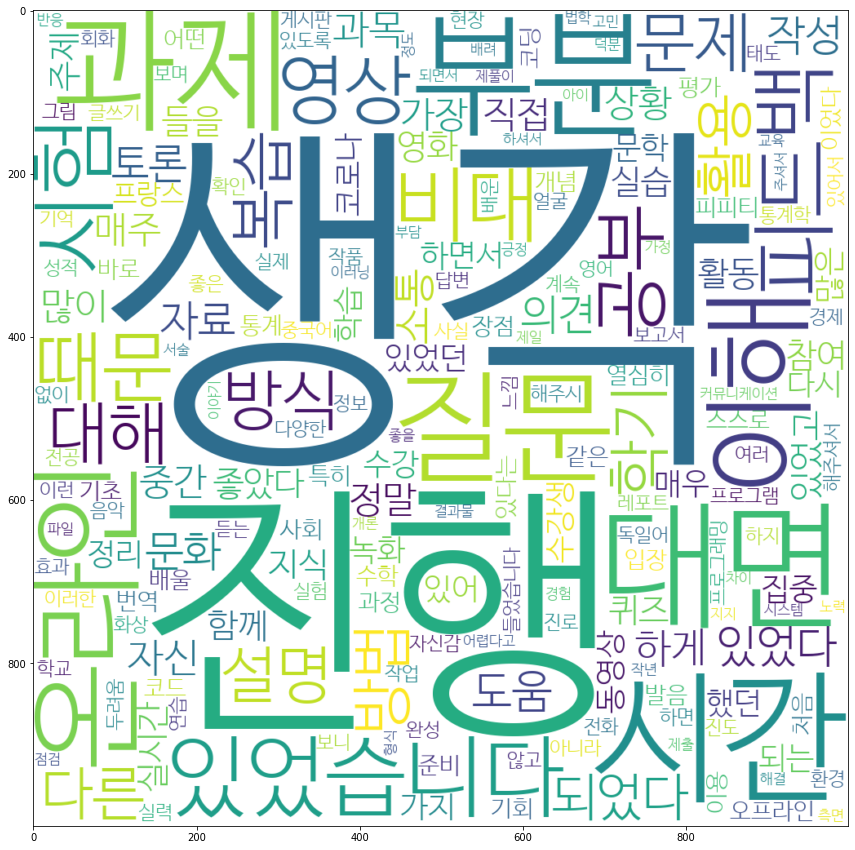

In [ ]:
# 수업평가 워드클라우드를 생성합니다. 
logging("Word Cloud를 생성합니다.")
# 워드클라우드를 그릴 환경을 설정합니다. (폰트, 그림 크기, 배경색)
wc = WordCloud(font_path= '/content/drive/My Drive/colab notebooks/textmining/NanumBarunGothicLight.ttf', background_color='white', width=1000, height=1000)

wordcloud = wc.generate(words_for_cloud_string)
fig = plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('/content/drive/My Drive/colab notebooks/textmining/result/wordcloud_eval.jpg')

In [ ]:
# 수업 운영 방식(strc)에 대한 감성 분석 결과를 포함한 데이터입니다 

textmining_data3 = pd.read_csv("/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis3.csv", encoding = "UTF-8") 

In [ ]:
# 학생의 노력에서 출연 빈도 수가 높은 상위 10개 토큰을 추출하는 함수입니다. 

def get_most_common_word(token_list, num):
    words = nltk.Text(token_list)
    word_list = []
    for word in words.vocab().most_common(num):
        word_list.append(word[0])
    return word_list

In [ ]:
# 수업 운영 방식에서 출연 빈도가 높은 상위 10개의 토큰들을 추출하고, 
# 이 토큰들을 words_for_cloud 라는 하나의 리스트로 합칩니다. 

words_for_cloud = []
for i in tqdm(range(0,len(blog_data))):
    token_list = get_token(textmining_data3["tokens"][i])

    # 앞서 정의한 get_most_common_word 함수가 여기서 실행됩니다. 
    words_for_cloud = words_for_cloud + get_most_common_word(token_list, 10)

# 리스트를 문자열 형태로 변환해줍니다. 
words_for_cloud_string = " ".join(words_for_cloud) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


| 2020-11-13 | 11:40:05 | Word Cloud를 생성합니다.



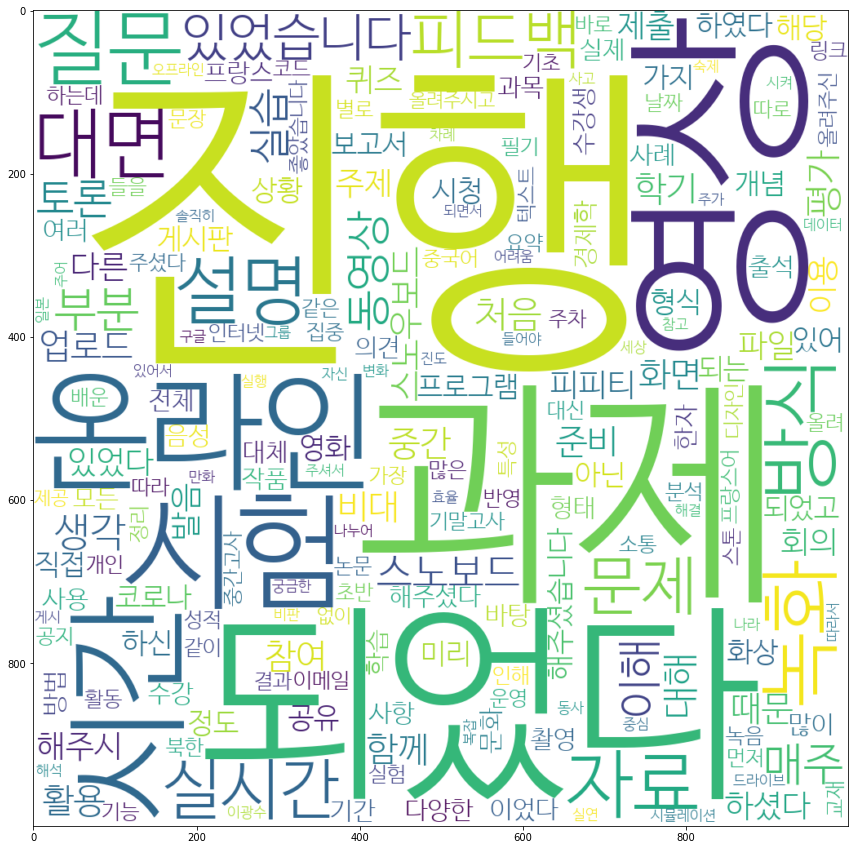

In [ ]:
# 수업 운영 방식 워드클라우드를 생성합니다. 
logging("Word Cloud를 생성합니다.")
# 워드클라우드를 그릴 환경을 설정합니다. (폰트, 그림 크기, 배경색)
wc = WordCloud(font_path= '/content/drive/My Drive/colab notebooks/textmining/NanumBarunGothicLight.ttf', background_color='white', width=1000, height=1000)

wordcloud = wc.generate(words_for_cloud_string)
fig = plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('/content/drive/My Drive/colab notebooks/textmining/result/wordcloud_strc.jpg')

In [ ]:
# 수업 운영 방식에서 출연 빈도가 높은 상위 10개의 토큰들을 추출하고, 
# 이 토큰들을 words_for_cloud 라는 하나의 리스트로 합칩니다. 

words_for_cloud = []
for i in tqdm(range(0,len(blog_data))):
    token_list = get_token(textmining_data3["pos"][i])

    # 앞서 정의한 get_most_common_word 함수가 여기서 실행됩니다. 
    words_for_cloud = words_for_cloud + get_most_common_word(token_list, 10)

# 리스트를 문자열 형태로 변환해줍니다. 
words_for_cloud_string = " ".join(words_for_cloud) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
# 학생의 노력(effort)에 대한 감성 분석 결과를 포함한 데이터입니다 

textmining_data2 = pd.read_csv("/content/drive/My Drive/colab notebooks/textmining/result/textmining_analysis2.csv", encoding = "UTF-8") 

In [ ]:
# 학생의 노력에서 출연 빈도 수가 높은 상위 10개 토큰을 추출하는 함수입니다. 

def get_most_common_word(token_list, num):
    words = nltk.Text(token_list)
    word_list = []
    for word in words.vocab().most_common(num):
        word_list.append(word[0])
    return word_list

In [ ]:
# 학생의 노력에서 출연 빈도가 높은 상위 10개의 토큰들을 추출하고, 
# 이 토큰들을 words_for_cloud 라는 하나의 리스트로 합칩니다. 

words_for_cloud = []
for i in tqdm(range(0,len(blog_data))):
    token_list = get_token(textmining_data2["tokens"][i])

    # 앞서 정의한 get_most_common_word 함수가 여기서 실행됩니다. 
    words_for_cloud = words_for_cloud + get_most_common_word(token_list, 10)

# 리스트를 문자열 형태로 변환해줍니다. 
words_for_cloud_string = " ".join(words_for_cloud) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


KeyError: ignored